# Slightly Less Toy Problem Optimization

This notebook explores what happens when you take the two-link rope toy problem and pull the rope to the right


### Reminder of the Objective


$$ \underset{A,B,C,D}{\mathrm{argmin}} || || + | (g - A - c(s_t)|

In [20]:
import notebook_finder
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)
import scipy.optimize as optimize
import toy_problem_optimization_common as tpo
from IPython.display import HTML

### Define goal

Our goal will be denoted as $g$, for now we simply assume its defined in the full state space

In [21]:
g = np.array([[5], [0], [6], [0]])

# Load Gazebo Data

In [22]:
drag_data = tpo.load_gazebo_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/0_80_pull_1.txt", g)

In [26]:
HTML('<img src="media/research/0_80_pull_1.gif">')

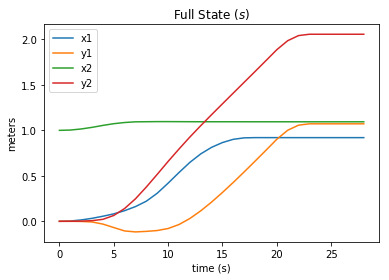

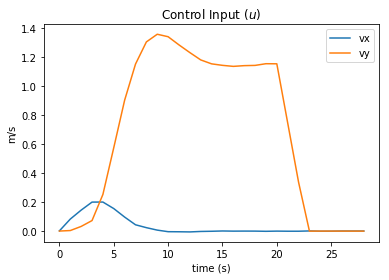

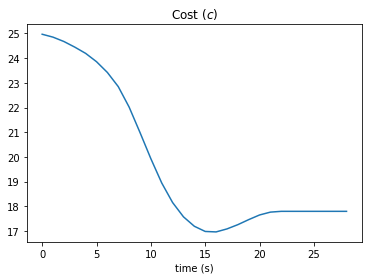

In [4]:
tpo.plot_gz_data(drag_data)

### How well do Random Parameters Do (on average)

In [6]:
N = 1000
costs = np.zeros(N)
model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
for i in range(N):
    random_params = np.random.randn(18)
    model.from_params(random_params)
    costs[i] = tpo.latent_prediction_objective(model, g, drag_data)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 517.847


### See how our previous model reduction transfers

To use the same models, the dimensionality of the input data must be the same.

In [7]:
old_params = np.array([-0.11, 0, 0.16, 0, -2, 0.81, 0, 347.77])
old_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
print("Objective Cost/Loss transfering to more complicated simulation:",
      tpo.latent_prediction_objective(old_model, g, drag_data))

Objective Cost/Loss transfering to more complicated simulation: 111304552.3457834


These parameters don't transfer well at all! That's because all those free parameters happened to be set to huge numbers, which blow up our cost as soon as we move a little bit in the y direction.

### Show that our old hand-designed parameters still works sort of well

It won't work nearly as well as before (in the pos-x gazebo experiment it scored ~0.0000265)

In [8]:
old_gz_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=1, L=2)
old_gz_model.from_params([1, 0, 0, 0, 0, 0.1, 0, 1])
print("Objective Cost/Loss:", tpo.latent_prediction_objective(old_gz_model, g, drag_data))

Objective Cost/Loss: 0.10093235576961647


### Show that our new hand designed model reduction does slightly better

In this model reduction, we compute the distance 

In [37]:
xy_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
xy_model.from_matrices(np.array([[1,0,0,0],[0,1,0,0]]), np.array([[0,0]]), np.array([[0.1,0],[0,0.1]]), np.array([[1,0],[0,1]]))
print("Objective Cost/Loss:", tpo.latent_prediction_objective(xy_model, g, drag_data))

Objective Cost/Loss: 0.0013686169355436038


In [38]:
# Do an example rollout
actions = [d[1] for d in drag_data]
s0 = np.array([[0], [0], [1], [0]])
o = xy_model.reduce(s0)
predicted_total_cost = 0
o_s = []
for u in actions:
    c_hat = xy_model.cost_of_o(o, g)
    o = xy_model.predict_from_o(o, u)
    o_s.append(o)

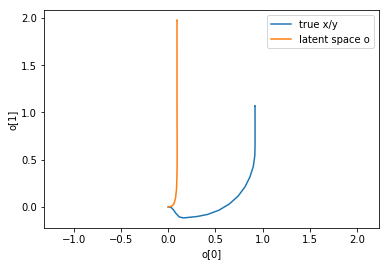

In [39]:
states = [d[0] for d in drag_data]
plt.plot([s[0,0] for s in states], [s[1,0] for s in states], label='true x/y')
plt.plot([o[0] for o in o_s], [o[1] for o in o_s], label='latent space o')
plt.xlabel("o[0]")
plt.ylabel("o[1]")
plt.axis("equal")
plt.legend();

### Try to optimize on our new data


In [46]:
drag_predictive_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=4, M=2, L=2)
tpo.train(drag_data, drag_predictive_model, g, tpo.latent_prediction_objective)
print("Objective Cost/Loss:", tpo.latent_prediction_objective(drag_predictive_model, g, drag_data))
drag_predictive_model.print()

Finished in 22 iterations
Objective Cost/Loss: 0.07287910535342002
Model reduction Matrix: [[ 5.227 -2.783 -2.311  1.168]
 [-1.047  0.781 -0.218 -2.358]]
Dynamics Matrices: [[-0.054 -0.017]] , [[ 0.468  0.235]
 [-1.403 -0.216]]
Cost Matrix: [[ 0.075 -0.537]
 [-0.35  -1.816]]


In [49]:
actions = [d[1] for d in drag_data]
s0 = np.array([[0], [0], [1], [0]])
o = drag_predictive_model.reduce(s0)
predicted_total_cost = 0
o_s = []
for u in actions:
    c_hat = drag_predictive_model.cost_of_o(o, g)
    o = drag_predictive_model.predict_from_o(o, u)
    o_s.append(o)
    predicted_total_cost += c_hat
print(predicted_total_cost)

[[531.514]]


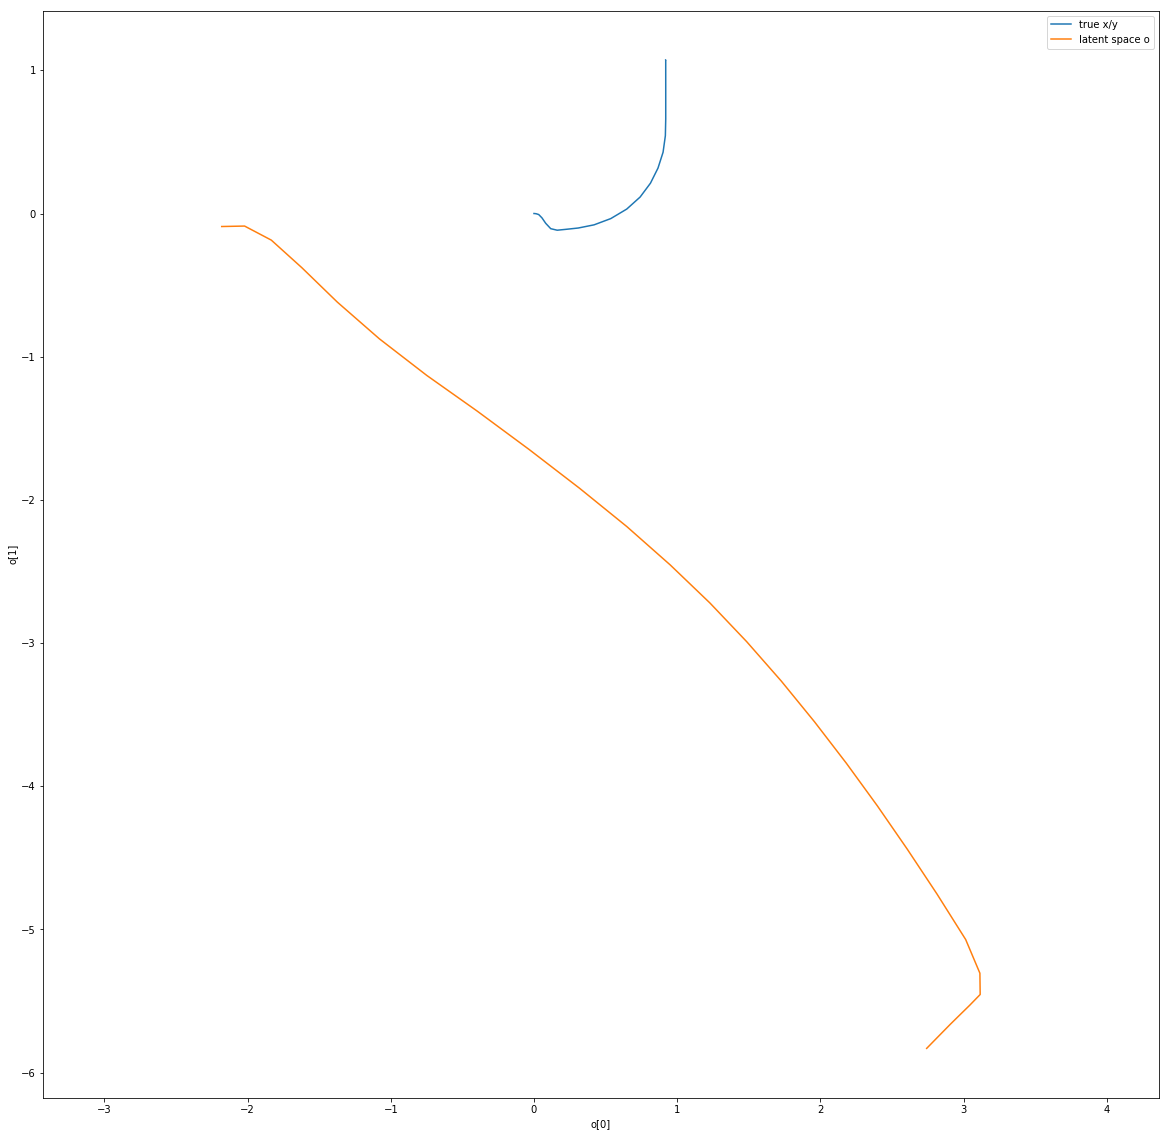

In [51]:
states = [d[0] for d in drag_data]
plt.figure(figsize=(20,20))
plt.plot([s[0,0] for s in states], [s[1,0] for s in states], label='true x/y')
plt.plot([o[0] for o in o_s], [o[1] for o in o_s], label='latent space o')
plt.xlabel("o[0]")
plt.ylabel("o[1]")
plt.axis("equal")
plt.legend();